In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base: str = "./datasets/"

# Load Transactions dataset

In [8]:
transactions = pd.read_csv(
    base + "transactions.csv",
    names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'],
    dtype={'timestamp': np.uint32, 'blockId': np.uint32, 'txId': np.uint32, 'isCoinbase': np.uint8},
    parse_dates=True
)

#transactions[["timestamp", "blockId", "txId", "isCoinbase", "fee"]] = transactions[["timestamp", "blockId", "txId", "isCoinbase", "fee"]].apply(pd.to_numeric, downcast="unsigned")


#print(transactions.info())
#print(pd.concat([transactions.head(), transactions.tail()]))
#print(transactions.head())
#print(transactions.tail())

'''
max vals
timestamp: 1356997957 -> int64
blockId: 214562 -> int32
txId: 10572826 -> int32
isCoinbase -> np.bool_
fee: 17179869184 -> int64
'''
print(transactions.info())
print(transactions.memory_usage(deep=True))
print(transactions.nlargest(5, 'txId'))

'''
Index              128           128
timestamp     84582632      42291316
blockId       42291316      42291316
txId          42291316      42291316
isCoinbase    84582632      10572829
fee           84582632      84582632
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572829 entries, 0 to 10572828
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   timestamp   uint32
 1   blockId     uint32
 2   txId        uint32
 3   isCoinbase  uint8 
 4   fee         int64 
dtypes: int64(1), uint32(3), uint8(1)
memory usage: 211.7 MB
None
Index              128
timestamp     42291316
blockId       42291316
txId          42291316
isCoinbase    10572829
fee           84582632
dtype: int64
           timestamp  blockId      txId  isCoinbase     fee
10572828  1356997957   214562  10572826           0  100000
10572827  1356997957   214562  10572825           0  100000
10572826  1356997957   214562  10572824           0  100000
10572825  1356997957   214562  10572823           0  100000
10572824  1356997957   214562  10572822           0  100000


'\nIndex              128           128\ntimestamp     84582632      42291316\nblockId       42291316      42291316\ntxId          42291316      42291316\nisCoinbase    84582632      10572829\nfee           84582632      84582632\n'

# Load Inputs dataset

In [3]:
inputs = pd.read_csv(
    base + "inputs.csv",
    names=['txId', 'prevTxId', 'prevTxPos'],
    dtype={'txId': np.uint32, 'prevTxId': np.uint32, 'prevTxPos': np.uint16},
)

# Load Outputs dataset 

In [4]:
outputs = pd.read_csv(
    base + "outputs.csv",
    names=['txId', 'txPos', 'addressId', 'amount', 'scriptType'],
    dtype={'txId': np.uint32, 'txPos': np.uint16, 'addressId': np.uint32, 'amount': np.uint64, 'scriptType': 'category'}
)

print(outputs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24613799 entries, 0 to 24613798
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   txId        uint32  
 1   txPos       uint16  
 2   addressId   uint32  
 3   amount      uint64  
 4   scriptType  category
dtypes: category(1), uint16(1), uint32(2), uint64(1)
memory usage: 446.0 MB
None


# Load Mappings dataset

In [ ]:
mappings = pd.read_csv(
    base + "mappings.csv",
    names=['addressId', 'hash'],
    dtype={'addressId': str, 'hash': np.int32}
)

# Script table

In [ ]:
data = {'scriptCode': [0,1,2,3,4,5,6,7], 
        'scriptType':["Unknown", "P2PK", "P2KH", "P2SH", "RETURN", "EMPTY", "P2WPKH", "P2WSH"],
        'scriptSize': [0, 153, 180, 291, 0, 0, 0, 0]
       }

scripts = pd.DataFrame(
    data,
    #dtypes={'scriptCode': np.int8, 'scriptType': str, 'scriptSize': np.int8}
                  
)
print(scripts.info())
print(scripts)


# Number of transactions

         timestamp  txCount
0       1231006505        1
1       1231469665        1
2       1231469744        1
3       1231470173        1
4       1231470988        1
...            ...      ...
214464  1356996072      418
214465  1356996754      259
214466  1356997591      142
214467  1356997908        1
214468  1356997957      260

[214469 rows x 2 columns]


<Axes: title={'center': 'Numero di transazioni nel tempo'}, xlabel='timestamp'>

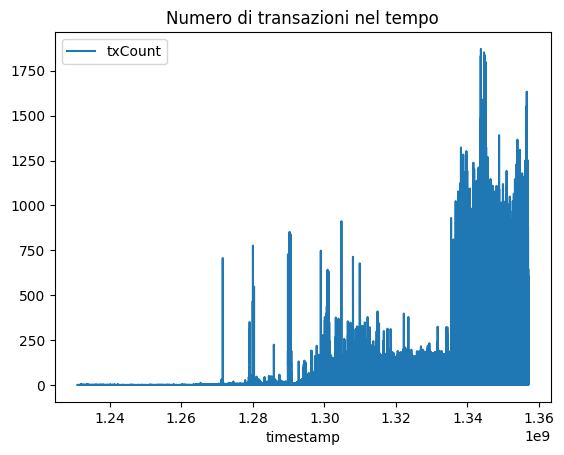

In [16]:
#Df to have the num of transactions for every timestamp
transCount = transactions \
    .groupby('timestamp')['txId'].count() \
    .reset_index() \
    .rename(columns={'txId':'txCount'})
print(transCount)

transCount.plot.line(title='Numero di transazioni nel tempo', x='timestamp', y='txCount')

# Utils

In [5]:
def getTransactionInputs(inputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    ''' Get all inputs of a transaction 
    
    Returns:
    DF<txId, prevTxId, prevTxPos>'''

    cond = inputsDf['txId'] == txId
    return inputsDf[cond]

def getTransactionOutputs(outputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    ''' Get all outputs of a transaction 
    
    Returns:
    DF<txId, txPos, addressId, amount, scriptType>'''
    
    cond = outputsDf['txId'] == txId
    return outputsDf[cond]

def getTransactionSize(inputsDf: pd.DataFrame, outputsDf: pd.DataFrame, txId: int) -> float:
    ''' Ottieni la dimensione di una transazione '''
    
    INPUT_SIZE = 40
    OUTPUT_SIZE = 9

    num_inputs = len(getTransactionInputs(inputsDf, txId))
    num_outputs = len(getTransactionOutputs(outputsDf, txId))
    script_size = 0

    # TODO: num_outputs > 1 ==> script diversi; quale contare?
    return INPUT_SIZE * num_inputs + OUTPUT_SIZE * num_outputs + script_size

def getTransactionsAtTimestamp(transactionsDf: pd.DataFrame, timestamp: int) -> pd.DataFrame:
    """ Get all transaction at a given timestamp 
    
    Returns:
    DF<timestamp, blockId, txId, isCoinbase, fee>"""

    cond = transactionsDf['timestamp'] == timestamp
    return transactionsDf[cond]


def getCongestionAtTs(timestamp: int, transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame) -> int:
    """ Get the congestion at a given timestamp """
    
    transactions_at_ts = getTransactionsAtTimestamp(transactionsDf, timestamp).drop(columns=["blockId", "isCoinbase", "fee"])
    # transactions_at_ts: <timestamp, txId>

    tx_sizes: list[float] = [getTransactionSize(inputsDf, outputsDf, txId) for txId in transactions_at_ts['txId']]
    return sum(tx_sizes)


def getAverageFeeAtTimestamp(timestamp: int, transactionsDf: pd.DataFrame) -> float:
    tx_ts: pd.DataFrame = getTransactionsAtTimestamp(transactionsDf, timestamp)

    return tx_ts['fee'].mean()


def getTsCongestionDf(transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame) -> pd.DataFrame:
    ''' STEPS:
    Filter transactionsDf (remove coinbases)
    Get timestamps
    Get congestion at timestamp
    Get fee at timestamp
    '''
    
    not_coinbase = transactionsDf['isCoinbase'] == 0
    transactionsDf = transactionsDf[not_coinbase]

    n = 572828
    
    timestamps = transactionsDf['timestamp'][n:n+500]
    congs = timestamps.apply(getCongestionAtTs, args=(transactionsDf, inputsDf, outputsDf))
    fees = timestamps.apply(getAverageFeeAtTimestamp, args=(transactionsDf))
    
    return pd.DataFrame({'Timestamp': timestamps, 'Congestion': congs, 'Fee': fees})

In [ ]:
# test getTransactionInputs, getTransactionOutputs
TX_ID = 10888

txInputs = getTransactionInputs(inputs, TX_ID)
print(f'#tx_inputs: {len(txInputs)}')
print(txInputs)

txOutputs = getTransactionOutputs(outputs, TX_ID)
print(f'#tx_outputs: {len(txOutputs)}')
print(txOutputs)

In [ ]:
#get all transactions with more then 1 output
'''
for id in transactions['txId']:
    n_outputs = len(getTransactionOutputs(outputs, id))

    if n_outputs != 1:
        print(f'txId:{id:}, num_outputs: {n_outputs}')

print("end")'''

In [ ]:
# test getTransactionsAtTimestamp
timestamp = 1356997591
transactions_ncb = transactions[transactions['isCoinbase'] == 0]

tx_ts = getTransactionsAtTimestamp(transactions_ncb, timestamp)

print(tx_ts)

In [ ]:
# test getCongestionAtTs
congestion = getCongestionAtTs(timestamp, transactions_ncb, inputs, outputs)
print(f'congestion @{timestamp}: {congestion}')


In [ ]:
# test getAverageFeeAtTimestamp
fee = getAverageFeeAtTimestamp(timestamp, transactions_ncb)
print(f'avg fee @{timestamp}: {fee}')

In [ ]:
# fee test
from datetime import datetime

ts_start = 1231006505
ts_end = 1356997957

random_ts = transactions.sample(n=5)['timestamp'].to_list()
print(random_ts)
#ts = random.randint(ts_start, ts_end)

for ts in random_ts:
    fee = getAverageFeeAtTimestamp(ts, transactions)
    print(f'avg fee @{ts}: {fee}')


# Analisi fee rispetto a congestione

In [28]:
transactions_ncb = transactions[transactions['isCoinbase'] == 0].drop(columns=['blockId', 'isCoinbase'])

# Merge transactions with inputs; then calculate size of inputs
merged_tx_inputs = pd.merge(transactions_ncb, inputs.drop(columns=['prevTxId', 'prevTxPos']), on='txId', how='inner')
size_inputs = merged_tx_inputs.groupby('txId').size().reset_index(name='num_inputs')

# Merge transactions with outputs; then calculate size of outputs
merged_tx_outputs = pd.merge(transactions_ncb, outputs.drop(columns=['txPos', 'addressId']), on='txId', how='inner')
size_outputs = merged_tx_outputs.groupby('txId').size().reset_index(name='num_outputs')

In [33]:
# Merge the sizes with transactions
merged_transactions = pd.merge(transactions_ncb, size_inputs, on='txId', how='left')
merged_transactions = pd.merge(merged_transactions, size_outputs, on='txId', how='left')

INPUT_SIZE = 40
OUTPUT_SIZE = 9

# Calculate size of each transaction
merged_transactions['transaction_size'] = merged_transactions['num_inputs'] * INPUT_SIZE + merged_transactions['num_outputs'] * OUTPUT_SIZE
merged_transactions = merged_transactions.drop(columns=['num_inputs', 'num_outputs'])

print(merged_transactions)

           timestamp      txId     fee  transaction_size
0         1231731025       171       0                58
1         1231740133       183       0                58
2         1231740736       185       0                58
3         1231742062       187       0                58
4         1231744600       192       0                49
...              ...       ...     ...               ...
10358261  1356997957  10572822  100000                58
10358262  1356997957  10572823  100000                58
10358263  1356997957  10572824  100000                58
10358264  1356997957  10572825  100000                58
10358265  1356997957  10572826  100000               107

[10358266 rows x 4 columns]


In [11]:
tt = merged_transactions.groupby('timestamp').agg({'fee': 'mean', 'transaction_size': 'sum'}).reset_index()
tt = tt.rename(columns={'fee': 'avgFee', 'transaction_size': 'congestion'})
print(tt)

         timestamp        avgFee  congestion
0       1231731025      0.000000          58
1       1231740133      0.000000          58
2       1231740736      0.000000          58
3       1231742062      0.000000          58
4       1231744600      0.000000          49
...            ...           ...         ...
130615  1356995372   2500.000000         766
130616  1356996072  86570.743405       45913
130617  1356996754  83062.015504       30225
130618  1356997591  39178.822695       11358
130619  1356997957  83861.003861       25663

[130620 rows x 3 columns]


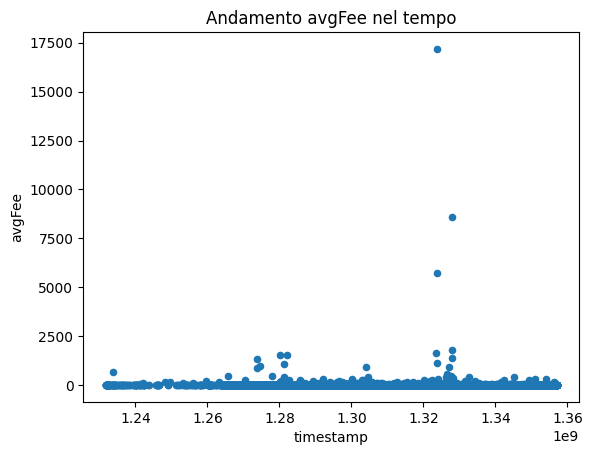

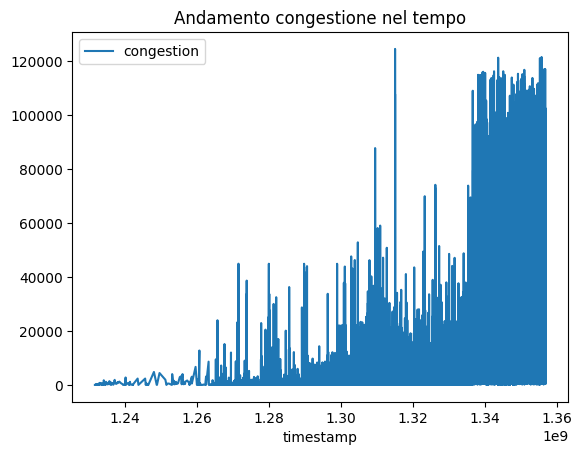

          timestamp     txId          fee
2017016  1323709065  2017014  17179869184
2013664  1323646760  2013662   8589934592
2303611  1327843019  2303609   6750450000
2303667  1327843568  2303665   6750450000
7633543  1349314186  7633541   6402609211
        timestamp        avgFee  congestion
74827  1323646760  17183.569184        4090
81848  1327843568   8572.357143        3034
74921  1323709065   5728.216508        3375
81846  1327843019   1776.973684        3297
74767  1323616207   1653.349611        9805


In [45]:
tt.plot.scatter(x='timestamp', y='avgFee', title='Andamento avgFee nel tempo')
tt.plot.line(x='timestamp', y='congestion', title='Andamento congestione nel tempo')
plt.show()

print(transactions_ncb.nlargest(5, 'fee'))
print(tt.nlargest(5, 'avgFee'))

Come si nota dai grafici, nonostante nel tempo la congestione della blockchain sia aumentata di qualche ordine di grandezza, lo stesso non si può dire per la fee media. Nonostante alcuni outlier, generalmente è rimasta al di sotto del valore 2500